<h1><center>The sensorimotor loop</center></h1>
 
In this notebook, we will look at a simple example of the simulation of a sensorimotor system. In the most abstract terms, we can think of such a system as being a *coupled system*, where an agent is coupled to its environment, and each can affect the other. The coupling, from the agent's perspective, is through its sensors and motors - it detects the environment through its sensors, and manipulates the environment, or its own position in the environment, through its motors. 

I will share a more advanced and complex example of simulating sensorimotor systems later in the module, but the objective with this notebook is only to explain the underlying principles with the simplest possible example.

<br><br>

<div> <img src="sensorimotor_couplings2.png" alt="Drawing" style="width: 400px;"/> </div>

<br><br>

There are various ways to describe and decompose the sensorimotor loop. In the decomposition which we will use here, the sensorimotor loop has the following elements (alternatively, components, or *subsystems*):

* Environment
* Sensors
* Controller
* Motor

These elements are connected in a *closed* loop, i.e. a loop which has no beginning or end. The early cyberneticians referred to the behaviour of systems with closed loops as *circularly causal*. Each element has an effect on the next: in the example in this notebook, the environment affects a sensor, which affects a controller, which affects a motor, which affects the environment, and so we are back to where we began and the loop is closed. Note that the choice of the environment as the first element in the previous sentence was entirely arbitrary - any element could be listed first when describing this pattern of connections. 

\[Also note: it is also worth mentioning that the environment is static in the example in this notebook, which means that it is not strictly affected by anything. However, it does change from the point of view of the *sensor*, as will be explained further below.\]

In [1]:
import matplotlib.pyplot as plt
import numpy as np

<div> <img src="1d_sensorimotor.png" alt="Drawing" style="width: 400px;"/> </div>


# The environment

In the most general terms, the environment of a system is everything which the system interacts with and which is *external* to it. For a physical system, or a simulation of a physical system, the environment is the space which the system inhabits and can move in, as well as any other object or force in that space which the system can affect or be affected by.

The environment in this notebook is a very simple one. It is 1-dimensional, with a single light positioned at a point on the line. A mobile agent moves up and down the line which describes the space of the environment, and so can either move closer to or further away from the light. The light is modelled with the `Light` class, given below. This light only has a position, and no other properties, or methods (i.e. it is static, and has no processes of its own). From this it follows that the environment in this notebook is also static, or unchanging.

Perhaps you are wondering how the sensorimotor loop can be closed if the environment does not change. It would be easy to think that having an element in a loop which does not change would block the transmission of information or signals around the loop, and would therefore break the circular causality of the system. This would in fact be true for all of the other elements in the system: if the sensor, controller, or motor were static, then the loop would be broken. However, because our sensor moves through the space of its environment, the environment does change *from the sensors point of view*, and so the loop is unbroken - as the agent moves, its sensor is moved. As the sensor is moved, its distance from the light changes, and so the output from the sensor changes. The change in the sensor output then (via controller and then motor) causes the agent to change its movement, and therefore the movement of its sensor. That takes us back to the place in the loop where we started, and then we go round the loop again and again until the simulation halts.

In [2]:
class Light:
    def __init__(self, x_pos):
        # set the position of the light
        self.x_pos = x_pos        

# The sensor

The sensor measures the distance from itself to the light. Therefore, it has position and also keeps a reference to the light. It is implemented in the `DistanceSensor` class, below.

In [3]:
class DistanceSensor:
    def __init__(self, x, light):
        # set the light which this sensor can detect
        self.light = light
        # set the position of the light
        self.x = x
        # we will keep a record of the outputs from the sensor for plotting later
        self.outputs = [0]
        
    def step(self):
        # get distance from x of light to x of this sensor
        output = self.light.x_pos - self.x
        self.outputs.append(output)
        return output

# The controller

For many sensorimotor systems, "controller" is a good general term for the element which maps from sensory inputs to motor outputs. It applies well to human-made sensorimotor systems, such as robots, self-driving cars, and autonomous drones. In the case of living sensorimotor systems, a nervous system, often including a brain, typically occupies the position of the controller, but that does not mean that control is all that a nervous system does - control is just one of a nervous system's roles.

Controllers, or control systems, can be complex, and can have internal dynamics and memory. The controller in our simple system, implemented below in `ProportionalController` (which you will recognise from an earlier example), is a very simple input-output system, which maps from sensory input to control output. It takes the sensor input value, multiplies by a gain (amplification) factor, and returns the result. Because the sensor outputs distance from the light, as the agent gets closer to the light the sensor output gets smaller, and so the output from the controller also gets smaller, meaning that the agent slows down as it approaches the light. The gain factor can be used to adjust how quickly the agent moves towards the light - for larger gain values, it will move faster.


In [4]:
class ProportionalController:

    def __init__(self, k):
        # controller gain
        self.k = k
        # we will keep a record of the outputs from the controller for plotting later
        self.outputs = [0]

    def step(self, e):
        # compute the controller output
        c = self.k * e
        # keep a record of the output
        self.outputs.append(c)
        # return the output
        return c

# The motor

Our agent moves using a simple motor, implemented in the `Motor` class below. Mathematically, it is identical to the `ProportionalController` class - it takes a control input, mutiplies it by a power (i.e. gain) factor, and returns the result. As with the gain parameter of the `ProportionalController`, larger power values will result in the agent moving faster than smaller ones.

In [5]:
class Motor:
    def __init__(self, power):
        # set the power of the motor
        self.power = power
        # we will record the motor's outputs over time
        self.outputs = [0]
    
    def step(self, control_signal):
        # compute the motor's output
        output = self.power * control_signal
        # record the output
        self.outputs.append(output)
        # return the output
        return output

# The agent

When connected to each other correctly, our sensor, controller and motor constitute a mobile sensorimotor system, or agent (an agent being a system which *acts*). This sensorimotor system is implementedin the `Agent` class, below. Due to the simplicity of our controller, our agent will do nothing at all unless it is coupled to an appropriate environment (this is very common for purely *reactive* systems like this one and Braitenberg's vehicles). In particular, if there was no light for our agent's sensor to detect, then the input to its controller would be zero, and so the agent would never move \[Note: in order to keep the code as simple and compact as possible here, I have not actually *implemented* the possibility of a sensor which detects no light.\]

If you look at the move method of the `Agent` class, you will see that the first line of code in it gets the sensor output. The second line of code uses the sensor input to get the controller output, and the third line of code uses the controller output and the motor to move the agent. In other words, the code follows the order of elements in the diagram of the sensorimotor agent given at the top of this notebook.

In [6]:
class Agent:
    def __init__(self, x, light):
        # set the Agent's x position
        self.x = x
        # we will keep a record of the Agent's postion over time
        self.xs = [x]
        # construct a distance sensor for the Agent to detect the passed in light
        self.sensor = DistanceSensor(x, light)
        # construct a motor for the Agent
        self.motor = Motor(1)
        # construct a controller for the Agent
        self.controller = ProportionalController(0.5)
        
    def step(self):
        # step the sensor subsystem - get distance from light
        sensor_val = self.sensor.step()
        # step the control subsystem, using the sensor output
        control_val = self.controller.step(sensor_val)
        # step the motor subsystem, and use its output to move the agent 
        self.x += self.motor.step(control_val)
        # record x position for plotting later
        self.xs.append(self.x)
        # move sensor with agent
        self.sensor.x = self.x

# The sensorimotor (simulation) loop

In principle, simulating a sensorimotor loop can be very simple, once all of the subsystems are programmed (this doesn't mean that it is necessarily easy to learn at first - although not complex, it requires a way of thinking which may be very new to you).  

Essentially, the simulation runs in *steps*, and in every simulation step the program goes round the sensorimotor loop once. In general, this requires the environment to be updated, and all agents to be updated. In this example, the environment is static, as explained above, and so does not need any updating. I have put a placeholder in the code to show where I might have updated the environment, if that was necessary, but - for a simulation as simple as this one - I could update the environment first and then the agents, instead the order given here. In some simulations, choosing the correct order to do updates in may be more important, and sometimes you may even want to update elements in pseudo-random order.

In this example, I have used a `while` loop to implement the sequence of simulation steps (I could have used a `for` loop, with only very small changes to the code, but I find `while` more convenient in this case). The simulation has a time variable, `t`, and every time the program executes the code in the while loop, the time variable steps forwards by the amount of time specified by `delta_t`. The simulation runs until the time variable reaches the value specified by `dur`.

In [9]:
# set up environment (a light)
light = Light(10)
# set up an agent which will detect the light
agent = Agent(15, light)

## prepare time variables
# set the interval of time that passes in every simulation step 
delta_t = 0.1 
# initialise the current time value
t = 0 
# we will keep a record of the time values in all simulation steps, used for plotting simulation data
ts = [t]
# the amount of simulation time units to run the simulation for 
dur = 5 

# run until the full simulation time has passes
while t < dur:
    
    # update (move) the agent
    agent.step()
    
    # update the environment
    # - not needed in this particular simulation
    
    # update time variables
    t += delta_t
    ts.append(t)

In the following plot, we see the agent's position over time. We can see that the agent initially moves rapidly from its initial position, at x=0, towards the position of the light, at x=10. As it gets closer to the light, it gradually slows down before stopping. This is sensible behaviour, but it is worth noting that the agent does this without any knowledge or rule of how to slow down, or even knowledge of what slowing down means - it achieves slowing down using only the simplest of mathematical functions and sensorimotor connections.

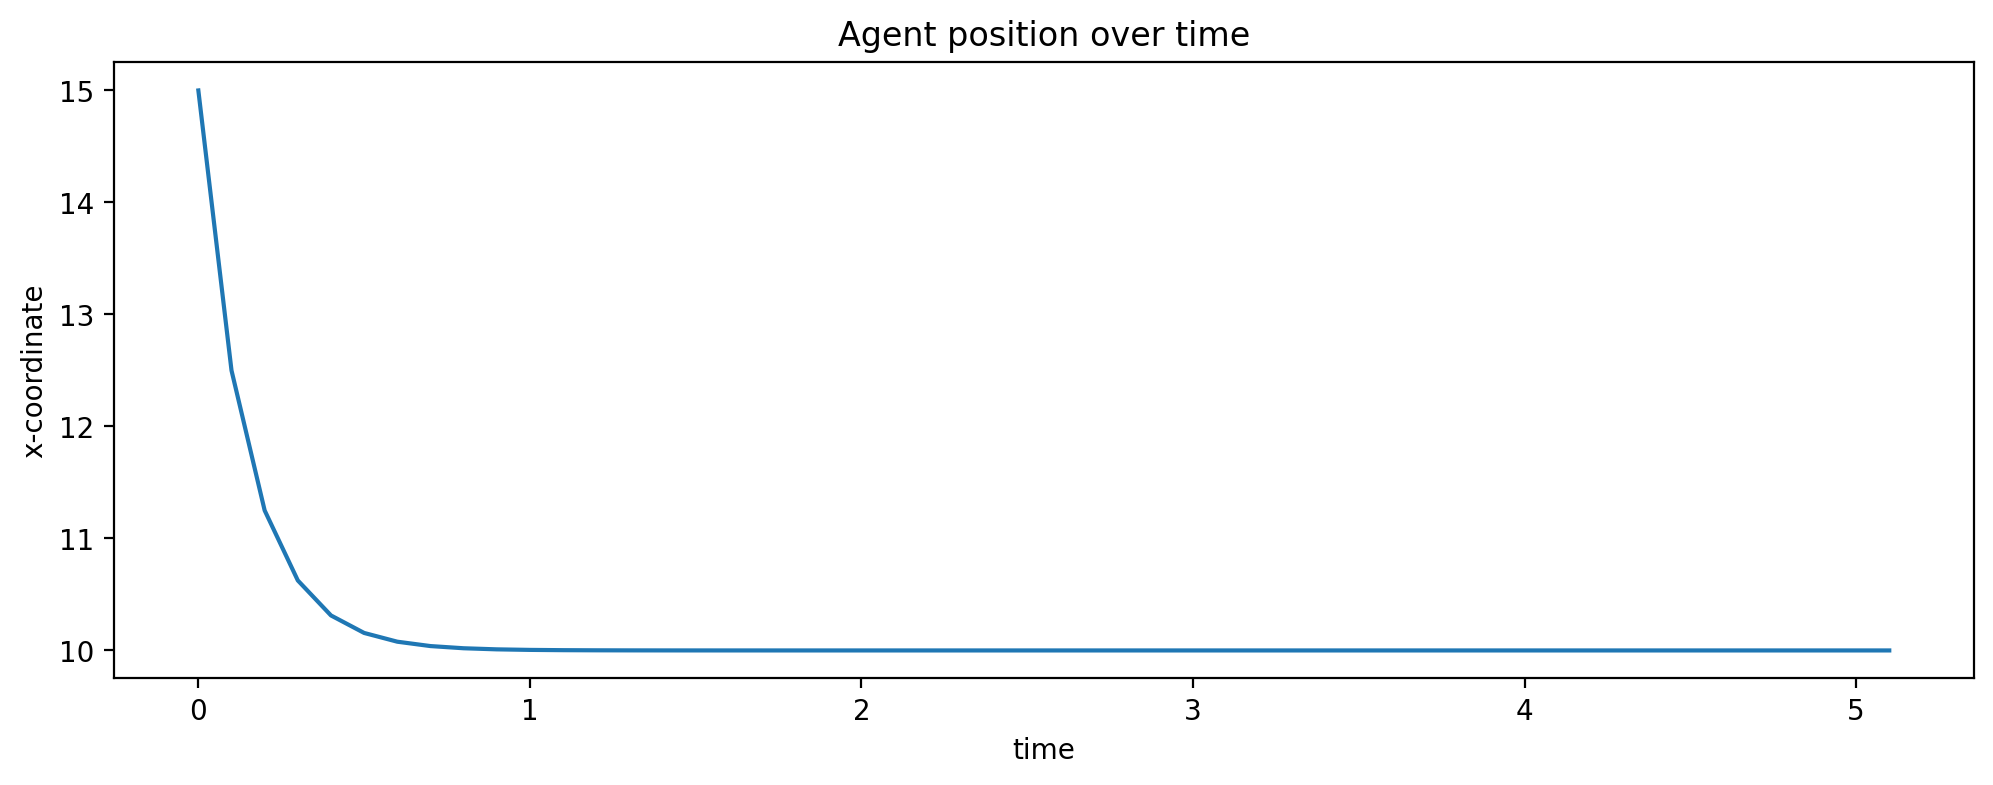

In [10]:
plt.figure(figsize=(12,4), dpi=200, facecolor='w', edgecolor='k')
plt.plot(ts, agent.xs)
plt.ylabel('x-coordinate')
plt.xlabel('time')
plt.title('Agent position over time')

plt.show()

You may have already realised, but our simple agent is working just like our earlier example of a simple negative feedback controlled system, with the goal of making the agent's postion equal to the position of the light. When we move to simulating light-seeking agents in 2 dimensions, this will no longer be the case, as the dynamics of the sensorimotor system will become more complex.

In the following plot, the agent's positions in the 1-dimensional environment are shown on the y-axis. Initially, when the agent moves very quickly, the points are very far apart, but after a small number of simulation steps the points are too close together to tell apart, as the agent slows down.

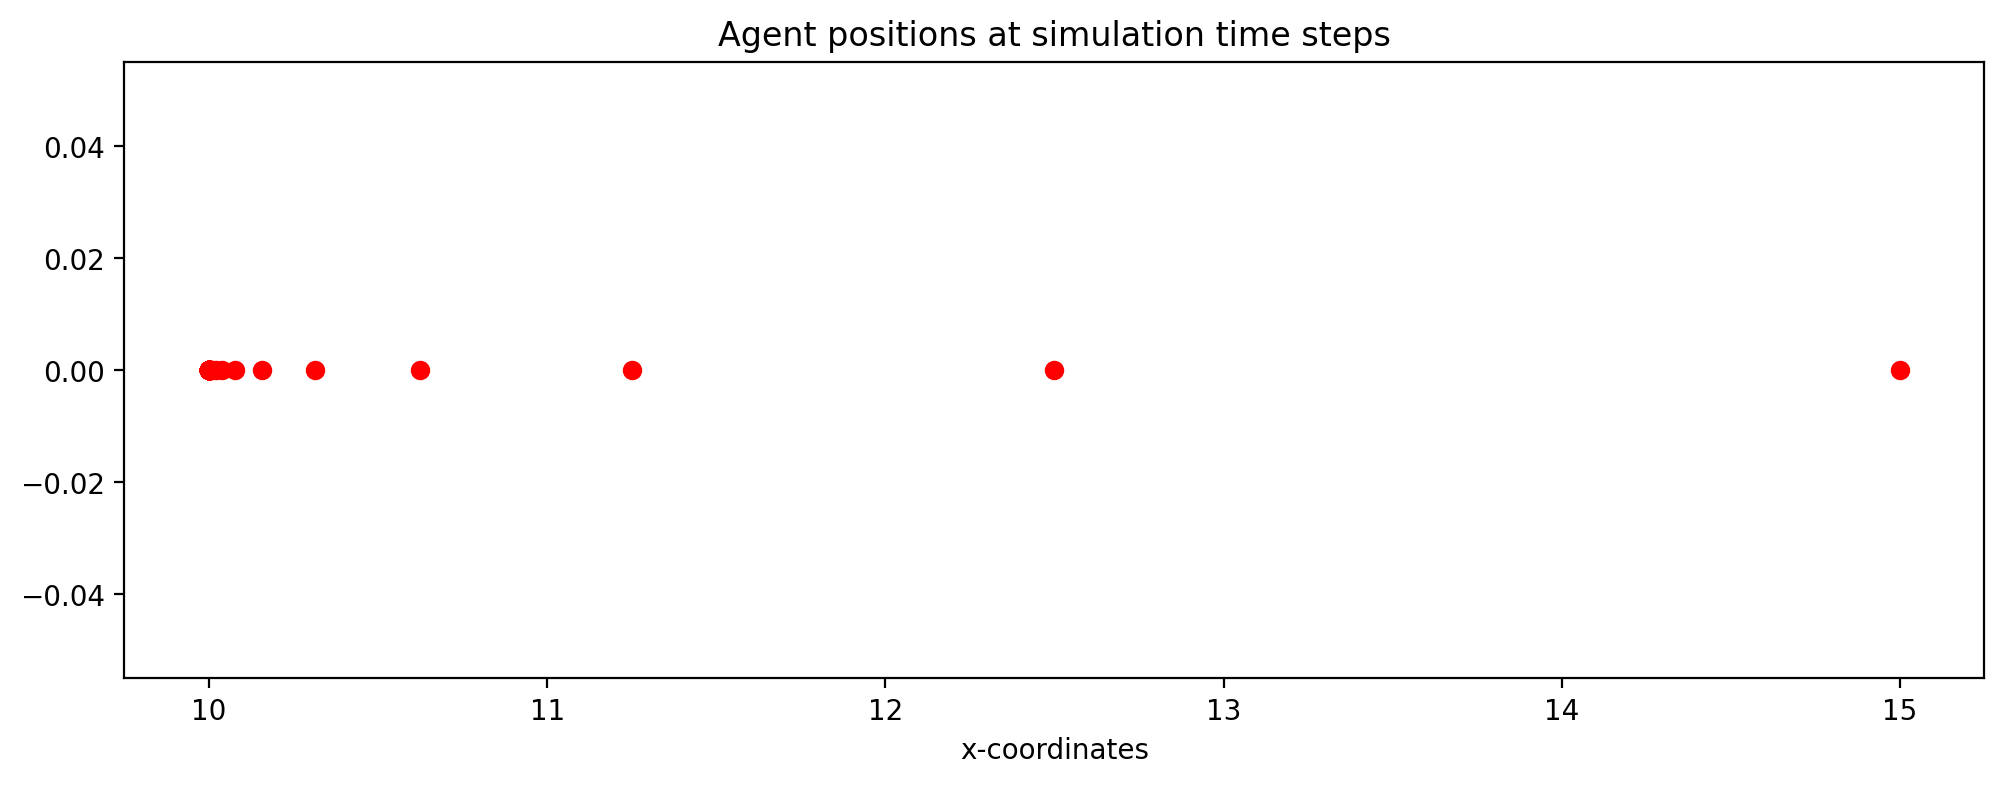

In [11]:

plt.figure(figsize=(12,4), dpi=200, facecolor='w', edgecolor='k')
plt.plot(agent.xs, np.zeros(len(agent.xs)), 'ro')
plt.xlabel('x-coordinates')
plt.title('Agent positions at simulation time steps')

plt.show()

The next plot is an example of how to plot the outputs of the subsystems of the agent. You will notice that at time *t = 0* all of the outputs are set to an initial value of *0*. They get updated the first time they are stepped, and then suddenly jump to different values. If we wanted to differentiate these time series, e.g. for purposes of analysis, then we might want to omit the initial *0* values. Conceptually, you can think of this issue as arising because the subsystems are switched on at time *t = 0*, and then it takes one timestep for them to update.

Text(0.5, 0, 'time')

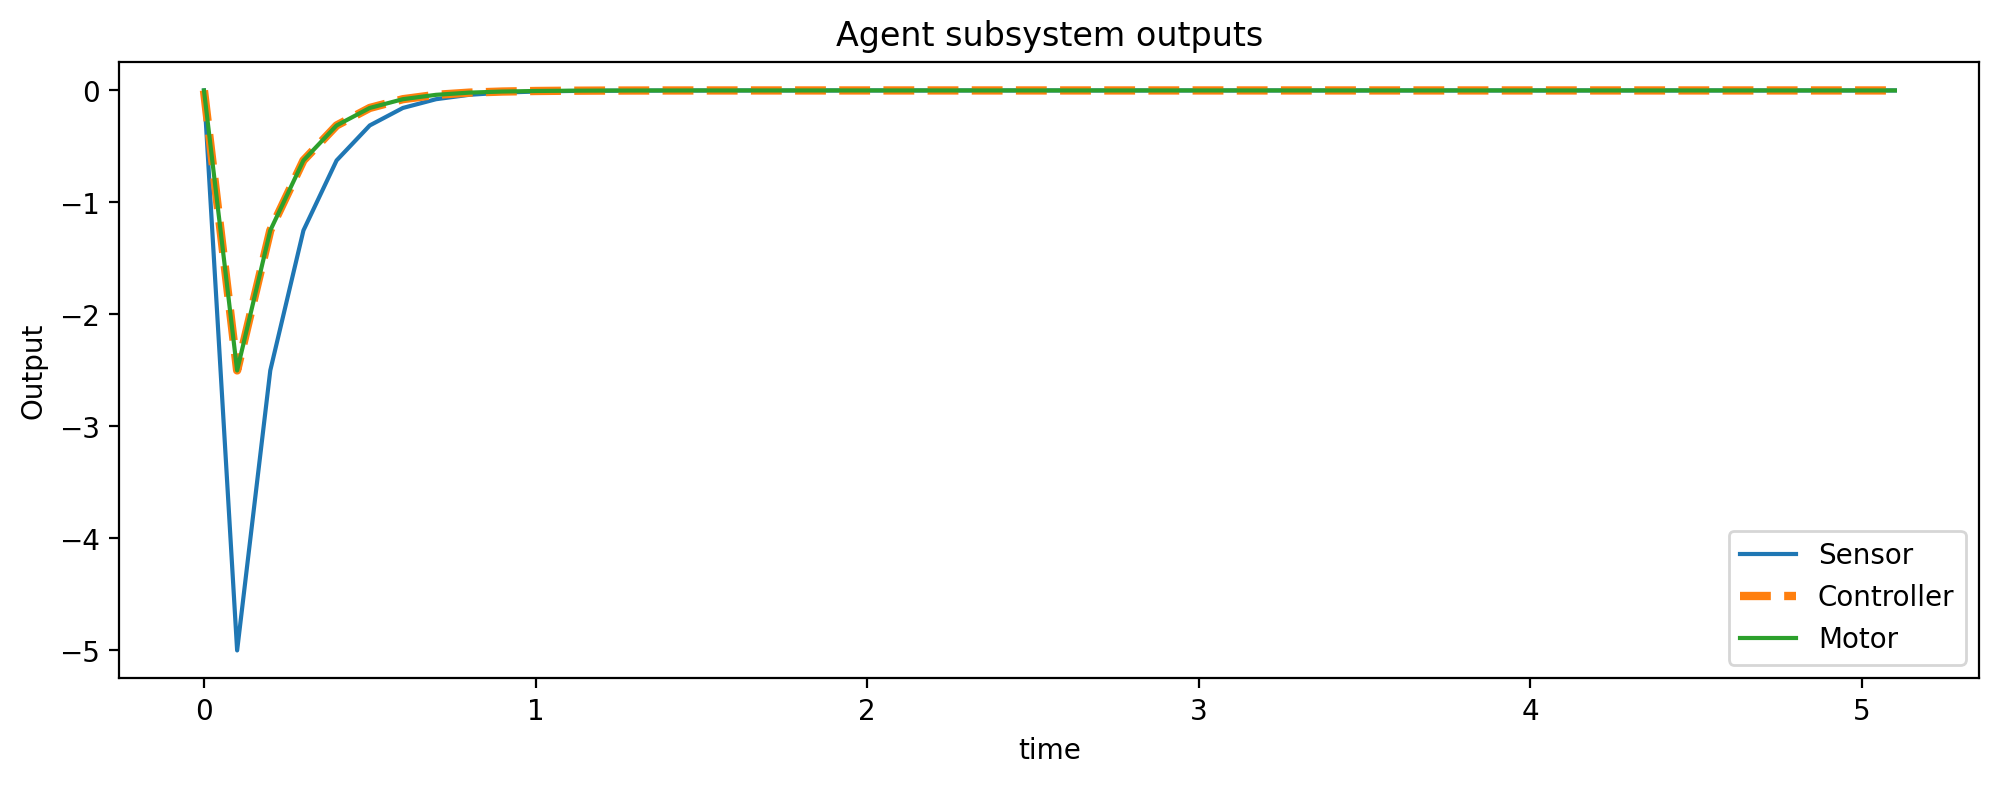

In [17]:
plt.figure(figsize=(12,4), dpi=200, facecolor='w', edgecolor='k')
plt.plot(ts, agent.sensor.outputs, label='Sensor')
plt.plot(ts, agent.controller.outputs, '--', linewidth=3, label='Controller')
plt.plot(ts, agent.motor.outputs, label='Motor')
plt.legend()
plt.title("Agent subsystem outputs")
plt.ylabel('Output')
plt.xlabel('time')